In [1]:
# import of necessary files from other folders

import os
import sys
import ast

# libraries imports

import importlib
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import seaborn as sns
import pandas as pd
import pickle

from IPython.display import Image, display
from PIL import Image
from pathlib import Path
from scipy.integrate import solve_ivp
from matplotlib.colors import LinearSegmentedColormap,TwoSlopeNorm

# Set default figure and axes background color to white
plt.rcParams['figure.facecolor'] = 'white'  # Background for the entire figure
plt.rcParams['axes.facecolor'] = 'white' 

# Function to check if a string can be converted to a float or an integer
def is_number(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [5]:
df_complete=pd.read_pickle('path to spatial_sr.pkl/lr')

/tmp/ipykernel_2456343/1945665262.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_extinction_times, shade=True, color="skyblue", alpha=0.7)


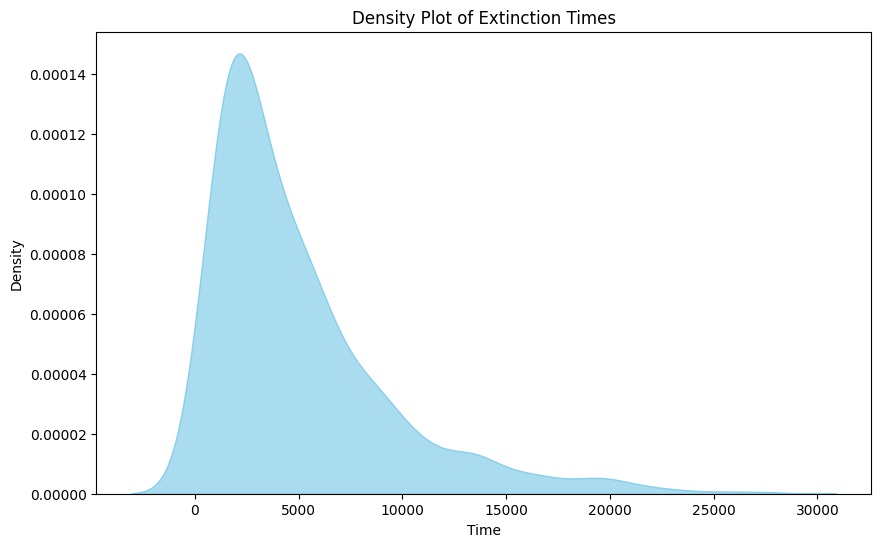

In [28]:

def find_extinction_times(timeseries, threshold=0.01):
    extinction_times = []
    for species_idx in range(timeseries.shape[1]):  # Iterate over species
        species_abundance = timeseries[:, species_idx]
        # Find the first time abundance goes below the threshold
        below_threshold = np.where(species_abundance < threshold)[0]
        if len(below_threshold) > 0:  # If it goes below the threshold
            extinction_times.append(below_threshold[0])  # Record the time
    return extinction_times

# Apply to each row in the dataframe
df_complete['extinction_times'] = df_complete['N_sp'].apply(
    lambda ts: find_extinction_times(np.array(ts))
)

# Collect all extinction times into a single list
all_extinction_times = [
    time for times_list in df_complete['extinction_times'] for time in times_list
]

# Plot the density
plt.figure(figsize=(10, 6))
sns.kdeplot(all_extinction_times, shade=True, color="skyblue", alpha=0.7)
plt.title("Density Plot of Extinction Times")
plt.xlabel("Time")
plt.ylabel("Density")
plt.show()

KS Statistic: 0.040831156376071376, p-value: 0.2047550289077653
Shape (σ): 0.8264839444830642, Scale (exp(μ)): 3584.525008907014


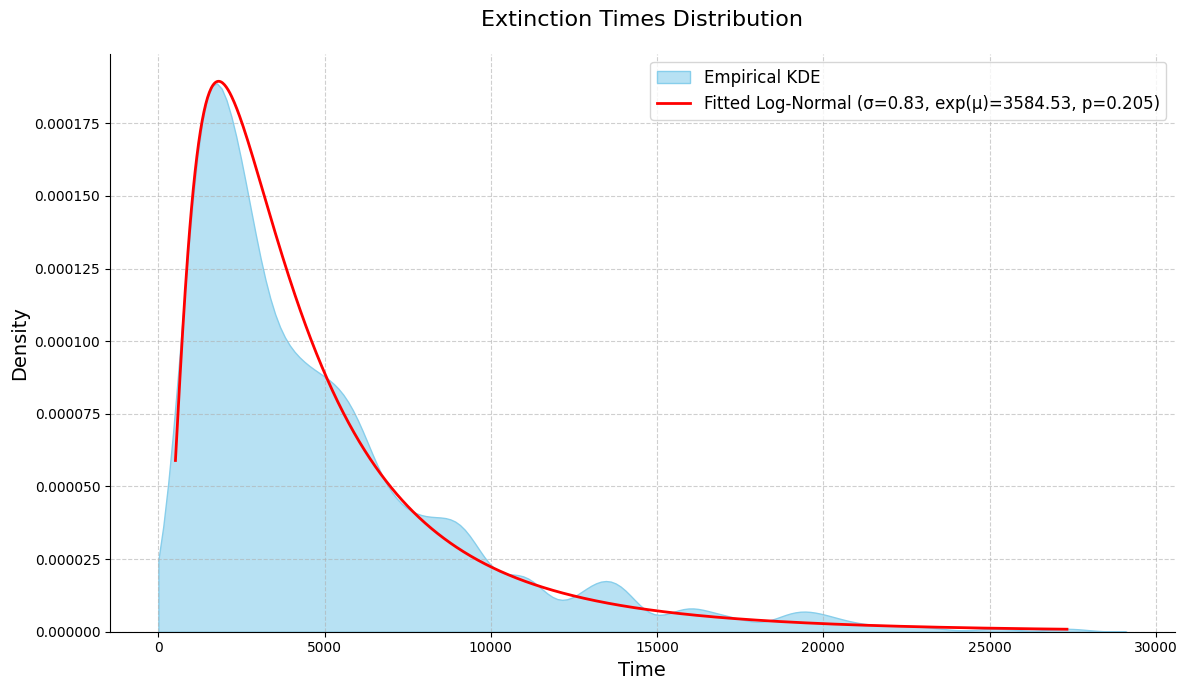

In [29]:
from scipy.stats import lognorm, kstest

# Fit a log-normal distribution to extinction times
shape, loc, scale = lognorm.fit(all_extinction_times, floc=0)  # floc=0 forces location to 0

# Kolmogorov-Smirnov test for goodness of fit
ks_statistic, p_value = kstest(all_extinction_times, 'lognorm', args=(shape, loc, scale))
print(f"KS Statistic: {ks_statistic}, p-value: {p_value}")
print(f"Shape (σ): {shape}, Scale (exp(μ)): {scale}")

# Generate x-values for plotting
x = np.linspace(min(all_extinction_times), max(all_extinction_times), 1000)

# Compute original PDF
pdf_original = lognorm.pdf(x, shape, loc=loc, scale=scale)

# Find probability mass in the negative region (x < 0)
neg_mass = lognorm.cdf(0, shape, loc=loc, scale=scale)

# Renormalize PDF to ensure total probability is still 1 after clipping
pdf_fitted = pdf_original / (1 - neg_mass)

# Plot the density
plt.figure(figsize=(12, 7))

# KDE Plot (empirical density)
sns.kdeplot(all_extinction_times, fill=True, color="skyblue", alpha=0.6, bw_adjust=0.5, label="Empirical KDE", clip=(0, np.inf))

# Fitted Log-Normal Distribution (Adjusted)
plt.plot(x, pdf_fitted, 'r-', lw=2, label=f"Fitted Log-Normal (σ={shape:.2f}, exp(μ)={scale:.2f}, p={p_value:.3f})")

# Titles & Labels
plt.title("Extinction Times Distribution", fontsize=16, pad=20)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.grid(True, linestyle='--', alpha=0.6)

# Legend
plt.legend(fontsize=12, frameon=True, loc='upper right')
sns.despine()  # Clean up borders
plt.tight_layout()  # Adjust layout to prevent overlap

# Show plot
plt.show()

In [31]:
# Given shape (sigma) and scale (exp(mu))
sigma = shape  # Log-normal shape parameter
scale = scale  # exp(mu), already extracted

# Compute the 95th percentile (the time after which there is less than a 5% chance of extinction events)
time_95th_percentile = lognorm.ppf(0.90, sigma, loc=0, scale=scale)

print(f"The minimum time after which there is less than a 10% chance of extinction events is: {time_95th_percentile:.2f}")

The minimum time after which there is less than a 10% chance of extinction events is: 10337.81


In [32]:
df_complete=df_complete[df_complete['N_sp'].apply(len)>10337.81]
len(df_complete)

398